In [84]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import glob
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import cv2
from PIL import Image
from IPython.display import Image
from IPython.display import display

from collections import defaultdict
from operator import itemgetter

pd.set_option('display.max_rows', 500)

In [4]:
main_folder = "../input/celeba-dataset/"
train_path = main_folder + "img_align_celeba/img_align_celeba/"
data_dir = pathlib.Path(train_path)

In [7]:
def load_data(main_folder, train_path):
    df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
    df_attr['path'] = train_path + df_attr['image_id']
    df_attr["Attractive"] = df_attr["Attractive"].astype('category')
    df_attr["Attractive"] = df_attr["Attractive"].cat.codes

    df_partition = pd.read_csv(main_folder + "list_eval_partition.csv")
    df_attr['partition'] = df_partition.partition

    # Filter Male instances
    df_attr = df_attr[df_attr['Male'] == 1]

    # Filter columns
    cols = ['image_id', 'Attractive', 'path', 'partition']
    df_attr = df_attr[cols]
    
    return df_attr

load_data(main_folder, train_path)

In [8]:
df_attr.head()

,image_id,Attractive,path,partition
2,000003.jpg,0,../input/celeba-dataset/img_align_celeba/img_a...,0
6,000007.jpg,1,../input/celeba-dataset/img_align_celeba/img_a...,0
7,000008.jpg,0,../input/celeba-dataset/img_align_celeba/img_a...,0
11,000012.jpg,1,../input/celeba-dataset/img_align_celeba/img_a...,0
12,000013.jpg,0,../input/celeba-dataset/img_align_celeba/img_a...,0


In [9]:
def configure_for_performance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

def decode_img(file_path, label):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [size, size]), label

def build_ds(fname, labels):
    ds = tf.data.Dataset.from_tensor_slices((fname, labels))
    ds = ds.shuffle(len(fname))
    ds = ds.map(decode_img, num_parallel_calls=AUTOTUNE)
    ds = configure_for_performance(ds)
    return ds

In [10]:
batch_size = 128
size = 128

AUTOTUNE = tf.data.experimental.AUTOTUNE

fname_train = df_attr[df_attr['partition'] == 0]['path']
labels_train = df_attr[df_attr['partition'] == 0]['Attractive']

fname_val = df_attr[df_attr['partition'] == 1]['path']
labels_val = df_attr[df_attr['partition'] == 1]['Attractive']

fname_test = df_attr[df_attr['partition'] == 2]['path']
labels_test = df_attr[df_attr['partition'] == 2]['Attractive']

train_ds = build_ds(fname_train, labels_train)
val_ds = build_ds(fname_val, labels_val)
test_ds = build_ds(fname_test, labels_test)

data = {
    'train_ds': train_ds,
    'val_ds': val_ds, 
    'test_ds': test_ds
}

In [12]:
class Tuner(object):

    def __init__(self, architecture, data, classes, epochs, batch_size):
        self.input_shape = (128, 128, 3)

        self.base_arch = architecture
        self.nn = self.download_network()
        self.nn.trainable = False

        self.classes = classes

        self.train_ds = data['train_ds']
        self.val_ds = data['val_ds']
        self.test_ds = data['test_ds']

        self.EPOCHS = epochs
        self.BATCH_SIZE = batch_size

        self.model = self.build()
        self.predictions = None
        self.score = None

        self.best_weights = None

    def download_network(self):
        '''
        Download the requested CNN with imagenet weights
        '''
        nn = None

        if self.base_arch == 'VGG16':
            nn = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'VGG19':
            nn = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'InceptionV3':
            nn = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet121':
            nn = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'DenseNet201':
            nn = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'ResNet152V2':
            nn = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'MobileNet':
            nn = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=self.input_shape)
        elif self.base_arch == 'MobileNetV2':
            nn = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=self.input_shape)

        return nn

    def run(self):
        '''
        Main driver for Learner object
        '''
        self.fine_tune()

    def build(self):
        '''
        Build model. Add Dense layer to topless base CNN.
        '''

        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Input(shape=self.input_shape))
        model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255))
        model.add(self.nn)
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dropout(0.25))
        model.add(tf.keras.layers.Dense(1024, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(0.25))
        model.add(tf.keras.layers.Dense(self.classes, activation='softmax'))
        print (model.summary())

        return model

    def load_weights(self, name):
        '''
        Load the best checkpointed weights.
        '''
        print('\nLoading best accuracy weights.')
        self.model.load_weights(name)

    def fine_tune(self):
        '''
        Fine-tune network in 2 phases
        '''

        print ("\nPhase A - Training Fully Connected Layers\n")
        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])

        # Define checkpoint to save best Phase 1 weights
        best_weights_ph1 = self.base_arch + "_ph1_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph1, monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

        history = self.model.fit(
            self.train_ds,
            epochs=self.EPOCHS,
            validation_data=self.val_ds,
            callbacks=[checkpoint])
        
        # Store the best phase 1 accuracy
        best_acc_ph1 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph1)

        print('\nRestoring best weights and predicting validation set.')
        self.load_weights(best_weights_ph1)

        # Make predictions based on best phase 1 weights
        self.predict()

        self.plot_loss(history, self.EPOCHS, 'Transfer Learning: ' + self.base_arch + ' Ph A')


        print ("\nPhase B  - Fine Tune all Layers \n")
        # Set full original CNN as trainable
        self.nn.trainable = True

        self.model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=1e-5), metrics=['accuracy'])

        # Define checkpoint to save best Phase 2 weights
        best_weights_ph2 = self.base_arch + "_ph2_weights.hdf5"
        checkpoint = tf.keras.callbacks.ModelCheckpoint(best_weights_ph2, monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)

        # Fine-tune the full CNN + FC
        history = self.model.fit(
            self.train_ds,
            epochs=self.EPOCHS,
            validation_data=self.val_ds,
            callbacks=[checkpoint])

        # Store the best phase 2 accuracy
        best_acc_ph2 = max(history.history["val_accuracy"])
        print('\n\nMax validation accuracy:', best_acc_ph2)

        # Only if Phase 2 fine-tuning resulted in a better accuracy than phase 1,
        # restore best phase 2 weights and update Tuner predictions.
        if best_acc_ph2 > best_acc_ph1:
            print('\nPhase 2 resulted in better accuracy than Phase 1.')
            print('Restoring best weights of Ph2 and predicting validation set.')
            self.load_weights(best_weights_ph2)
            self.predict()

        self.plot_loss(history, self.EPOCHS, ' Transfer Learning: ' + self.base_arch + ' Ph B')
    
    def predict(self):
        '''
        Get predictions and score for validation set.
        '''
        print('\nPredicting test set classes.')
        self.score = self.model.evaluate(self.test_ds, verbose=0)
        print('Test set score:', self.score)
        self.predictions = self.model.predict(self.test_ds, batch_size=self.BATCH_SIZE)
        print('Done')

    def plot_loss(self, history, epochs, name):
        print('\n\n')
        plt.figure(figsize=(12,8))
        plt.plot(np.arange(0, epochs), history.history["loss"], label="train_loss")
        plt.plot(np.arange(0, epochs), history.history["val_loss"], label="val_loss")
        plt.plot(np.arange(0, epochs), history.history["accuracy"], label="train_acc")
        plt.plot(np.arange(0, epochs), history.history["val_accuracy"], label="val_acc")
        plt.title("Training Loss and Accuracy - {}".format(name))
        plt.xlabel("Epoch #")
        plt.ylabel("Loss/Accuracy")
        plt.legend()
        plt.show()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 128, 128, 3)       0         
_________________________________________________________________
densenet201 (Model)          (None, 4, 4, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 30720)             0         
_________________________________________________________________
dropout (Dropout)            (None, 30720)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              31458304  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________

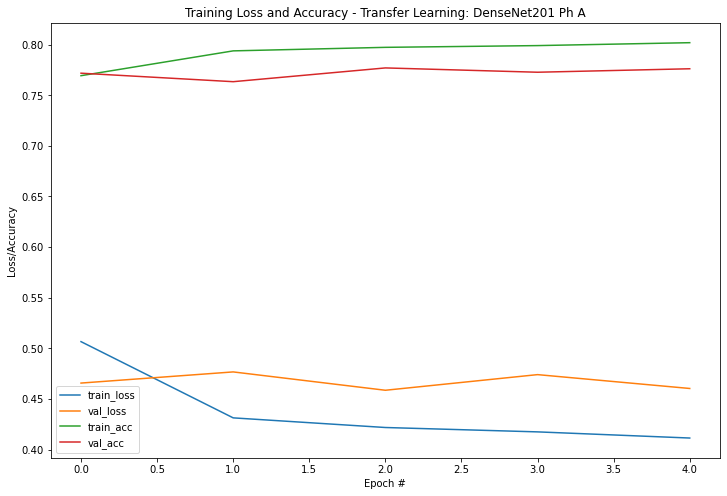


Phase B  - Fine Tune all Layers 

Epoch 1/5
534/534 [==============================] - ETA: 0s - loss: 0.4108 - accuracy: 0.8084
Epoch 00001: val_accuracy improved from -inf to 0.79747, saving model to DenseNet201_ph2_weights.hdf5
534/534 [==============================] - 220s 413ms/step - loss: 0.4108 - accuracy: 0.8084 - val_loss: 0.4187 - val_accuracy: 0.7975
Epoch 2/5
534/534 [==============================] - ETA: 0s - loss: 0.3290 - accuracy: 0.8505
Epoch 00002: val_accuracy improved from 0.79747 to 0.80917, saving model to DenseNet201_ph2_weights.hdf5
534/534 [==============================] - 217s 406ms/step - loss: 0.3290 - accuracy: 0.8505 - val_loss: 0.4109 - val_accuracy: 0.8092
Epoch 3/5
534/534 [==============================] - ETA: 0s - loss: 0.2701 - accuracy: 0.8833
Epoch 00003: val_accuracy did not improve from 0.80917
534/534 [==============================] - 213s 399ms/step - loss: 0.2701 - accuracy: 0.8833 - val_loss: 0.4316 - val_accuracy: 0.8024
Epoch 4/5
534

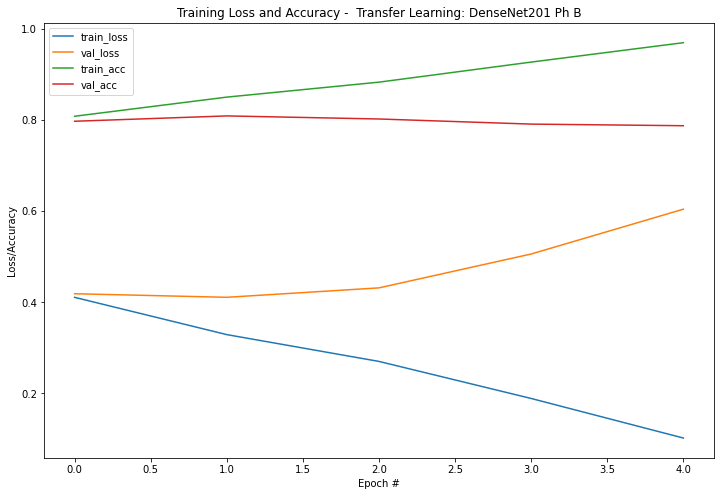

In [13]:
NET = 'DenseNet201'
EPOCHS = 5
BATCH_SIZE = 128
CLASSES = 2

tuner = Tuner(NET, data, CLASSES, EPOCHS, BATCH_SIZE)
tuner.run()

In [58]:
def plot(img):
    plt.imshow(img)
    plt.show()
    
def process_image(path):
    img = cv2.imread(str(path))
    img = img[:,:,::-1]
    
    x = 100
    y = 0
    h = 200
    w = 180
    img = img[y:y+h, x:x+w]

    img = cv2.resize(img, (128, 128))    
    img = np.expand_dims(img, axis=0)
    
    return img

In [79]:
def get_predictions(pathlist):
    print('\nPredicting face attractiveness...')
    results = defaultdict()
    
    for path in pathlist:
        img = process_image(path)
        pred = tuner.model.predict(img)
        
        name = str(path).split('/')[-1].split('.')[0].replace('_', ' ')
        team = str(path).split('/')[-2]
        #results[name] = pred[0][1]
        results[name] = defaultdict()
        results[name]['pred'] = pred[0][1]
        results[name]['team'] = team
        results[name]['path'] = str(path)
        
    return results

In [80]:
pathlist = Path('../input/bundesliga14teams/').glob('*/*/*.jpg')
res = get_predictions(pathlist)


Predicting face attractiveness...


In [85]:
df = pd.DataFrame(res)
df = df.transpose()
df.sort_values(by=['pred'], inplace=True, ascending=False)
df

,pred,team,path
Lucas Hernandez,0.97732,BayernMuenchen,../input/bundesliga14teams/Bundesliga1/BayernM...
Raphael Guerreiro,0.949747,BorussiaDortmund,../input/bundesliga14teams/Bundesliga1/Borussi...
Yann Sommer,0.899266,BorussiaMoenchengladbach,../input/bundesliga14teams/Bundesliga1/Borussi...
Marwin Hitz,0.899017,BorussiaDortmund,../input/bundesliga14teams/Bundesliga1/Borussi...
Thomas Meunier,0.874831,BorussiaDortmund,../input/bundesliga14teams/Bundesliga1/Borussi...
Torben Muesel,0.863904,BorussiaMoenchengladbach,../input/bundesliga14teams/Bundesliga1/Borussi...
Dani Olmo,0.855488,RBLeipzig,../input/bundesliga14teams/Bundesliga1/RBLeipz...
Sven Ulreich,0.85324,BayernMuenchen,../input/bundesliga14teams/Bundesliga1/BayernM...
Achraf Hakimi,0.843672,BorussiaDortmund,../input/bundesliga14teams/Bundesliga1/Borussi...
Benjamin Pavard,0.820361,BayernMuenchen,../input/bundesliga14teams/Bundesliga1/BayernM...


In [91]:
top = df.iloc[:20]
top

,pred,team,path
Lucas Hernandez,0.97732,BayernMuenchen,../input/bundesliga14teams/Bundesliga1/BayernM...
Raphael Guerreiro,0.949747,BorussiaDortmund,../input/bundesliga14teams/Bundesliga1/Borussi...
Yann Sommer,0.899266,BorussiaMoenchengladbach,../input/bundesliga14teams/Bundesliga1/Borussi...
Marwin Hitz,0.899017,BorussiaDortmund,../input/bundesliga14teams/Bundesliga1/Borussi...
Thomas Meunier,0.874831,BorussiaDortmund,../input/bundesliga14teams/Bundesliga1/Borussi...
Torben Muesel,0.863904,BorussiaMoenchengladbach,../input/bundesliga14teams/Bundesliga1/Borussi...
Dani Olmo,0.855488,RBLeipzig,../input/bundesliga14teams/Bundesliga1/RBLeipz...
Sven Ulreich,0.85324,BayernMuenchen,../input/bundesliga14teams/Bundesliga1/BayernM...
Achraf Hakimi,0.843672,BorussiaDortmund,../input/bundesliga14teams/Bundesliga1/Borussi...
Benjamin Pavard,0.820361,BayernMuenchen,../input/bundesliga14teams/Bundesliga1/BayernM...


In [92]:
low = df.iloc[-20:]
low

,pred,team,path
Amadou Haidara,0.0726096,RBLeipzig,../input/bundesliga14teams/Bundesliga1/RBLeipz...
Chris Richards,0.0719085,BayernMuenchen,../input/bundesliga14teams/Bundesliga1/BayernM...
Mario Goetze,0.0701476,BorussiaDortmund,../input/bundesliga14teams/Bundesliga1/Borussi...
Marius Wolf,0.0626508,BorussiaDortmund,../input/bundesliga14teams/Bundesliga1/Borussi...
David Alaba,0.0611461,BayernMuenchen,../input/bundesliga14teams/Bundesliga1/BayernM...
Christopher Nkunku,0.0549322,RBLeipzig,../input/bundesliga14teams/Bundesliga1/RBLeipz...
Erling Haaland,0.0545107,BorussiaDortmund,../input/bundesliga14teams/Bundesliga1/Borussi...
Marcus Thuram,0.052333,BorussiaMoenchengladbach,../input/bundesliga14teams/Bundesliga1/Borussi...
Famana Quizera,0.0494833,BorussiaMoenchengladbach,../input/bundesliga14teams/Bundesliga1/Borussi...
Aaron Herzog,0.0484752,BorussiaMoenchengladbach,../input/bundesliga14teams/Bundesliga1/Borussi...


In [93]:
def show_picture(path):
    img = cv2.imread(str(path))
    img = img[:,:,::-1]
    plt.imshow(img)
    plt.show()

def show_pictures(players):
    
    plt.figure(figsize=(20,20)) # specifying the overall grid size
    
    for i, (name, data) in enumerate(players.iterrows()):
        path = './' + data['path'].replace('\\', '/')
        plt.subplot(5,5,i+1)    # the number of images in the grid is 5*5 (25)
        img = cv2.imread(str(path))
        img = img[:,:,::-1]
        plt.imshow(img)
        plt.title(name + ' - ' + str(round(data['pred'], 4)))

    plt.show()

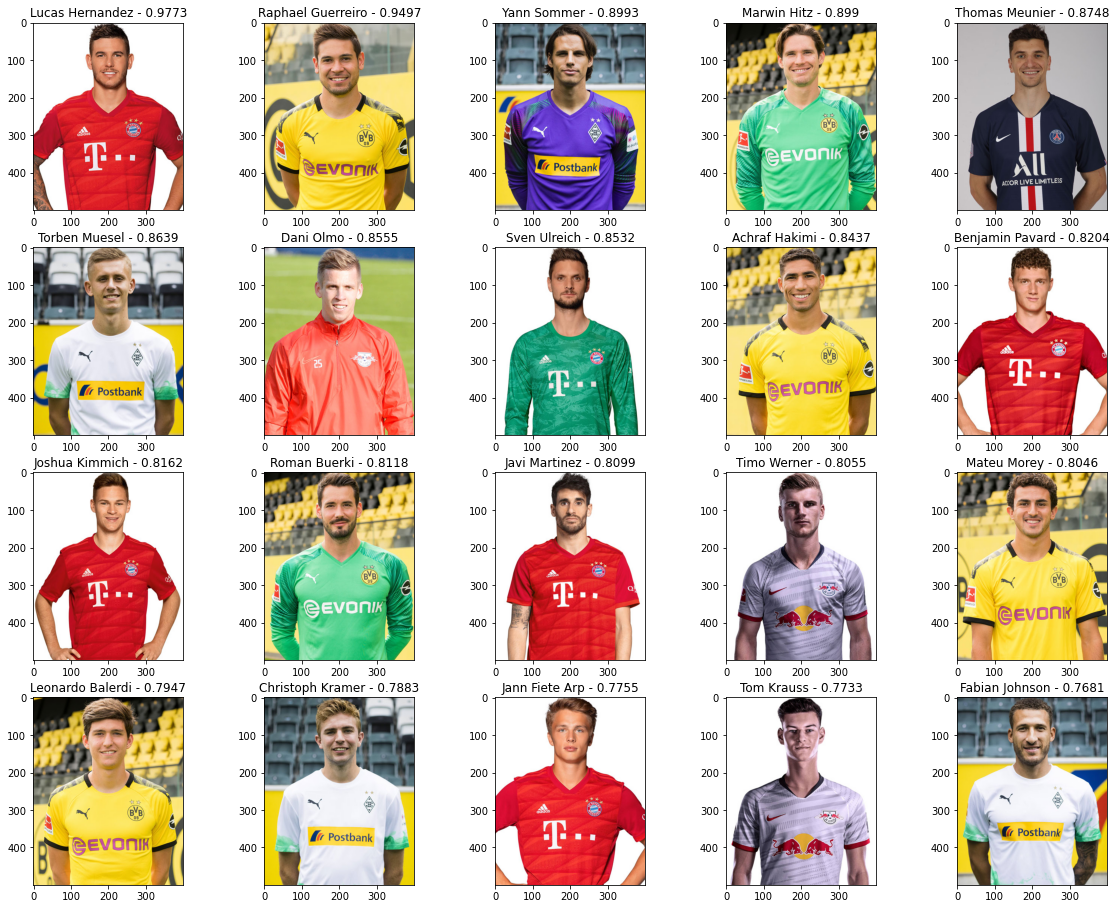

In [94]:
show_pictures(top)

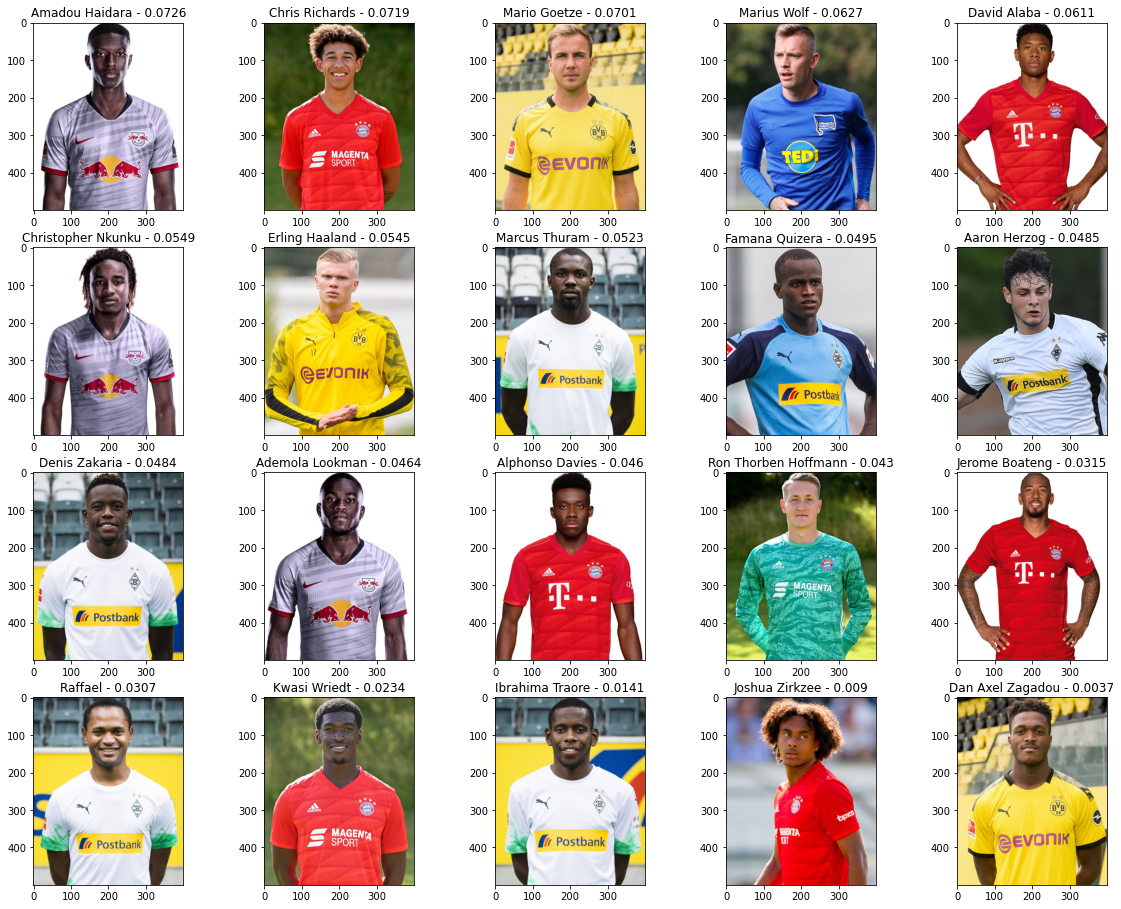

In [95]:
show_pictures(low)